## Deep Learning

In [1]:
import warnings

warnings.filterwarnings("ignore")
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to tune model, get different metric scores, and split data.
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#libraries to help with model building
from sklearn.ensemble import (
    AdaBoostRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
    BaggingRegressor)
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import metrics
warnings.filterwarnings("ignore")
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries to tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline

#libraries to help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier)
from xgboost import XGBClassifier

# to suppress scientifiv notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import pandas as pd
data=pd.read_csv('/content/gdrive/MyDrive/train-balanced-sarcasm.csv')
data.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [4]:
data.isnull().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [5]:
data['comment']=data['comment'].fillna('No Comment')

In [6]:
# Remove Emoji
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [7]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
from nltk.corpus import stopwords
from tqdm import tqdm
import re
stopwords = stopwords.words('english')
def preprocess(text_col,stopword):
    preprocessed = []
    for sentence in tqdm(text_col.values):
        # Replace "carriage return" with "space".
        sentence=str(sentence)
        sent = sentence.replace('\\r', ' ')
        # Replace "quotes" with "space".
        sent = sent.replace('\\"', ' ')
        # Replace "line feed" with "space".
        sent = sent.replace('\\n', ' ')
        # Replace characters between words with "space".
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        #remove stop words
        #decontraction
        sent=decontractions(sent)
        #Remove emoji
        sent=deEmojify(sent)
        if stopword:
            sent = ' '.join(e for e in sent.split() if e not in stopwords)
        else:
           sent = ' '.join(e for e in sent.split())
        # to lowercase
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [10]:
data['comment']=preprocess(data['comment'],stopword=False)

100%|██████████| 1010826/1010826 [00:27<00:00, 36619.45it/s]


In [11]:
data['parent_comment']=preprocess(data['parent_comment'],stopword=False)

100%|██████████| 1010826/1010826 [00:34<00:00, 29121.18it/s]


In [12]:
data.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [13]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

Polarity Score

In [14]:
import nltk
from tqdm import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
def generate_sentiment_scores(data):
    sid = SentimentIntensityAnalyzer()
    neg=[]
    pos=[]
    neu=[]
    comp=[]
    for sentence in tqdm(data['parent_comment'].values): 
        sentence_sentiment_score = sid.polarity_scores(sentence)
        comp.append(sentence_sentiment_score['compound'])
        neg.append(sentence_sentiment_score['neg'])
        pos.append(sentence_sentiment_score['pos'])
        neu.append(sentence_sentiment_score['neu'])
    return comp,neg,pos,neu

In [15]:
data['compound'],data['negative'],data['positive'],data['neutral']=generate_sentiment_scores(data)

100%|██████████| 1010826/1010826 [04:44<00:00, 3553.36it/s]


In [16]:
data['com_len']=data['comment'].apply(lambda x:len(x.split()))

In [17]:
data['parent_com_len']=data['parent_comment'].apply(lambda x:len(x.split()))

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Flatten,Reshape
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
import csv
from tensorflow.keras.models import Model
#import keras
from tensorflow.keras import backend as k
from tensorflow.keras.layers import Input,Concatenate,Dropout,Dense,BatchNormalization,Conv1D
from tensorflow.keras.layers import Input
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
#from tensorflow.keras.merge import concatenate
#import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import scipy
from tensorflow.keras.initializers import he_normal,glorot_normal
from tensorflow.keras.regularizers import l1,l2
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint,LearningRateScheduler,ReduceLROnPlateau
from time import time
from tensorflow.keras.utils import plot_model

In [19]:
labels=tf.keras.utils.to_categorical(data['label'].values,num_classes=2)
labels.shape

(1010826, 2)

In [20]:
data['comment']=data['comment']+" "+data['author']+" "+data['subreddit']+" "+data['parent_comment']

In [21]:
word_tokenizer = nltk.WordPunctTokenizer()
word_tokens = [word_tokenizer.tokenize(sent) for sent in tqdm(data['comment'].values)]

100%|██████████| 1010826/1010826 [00:13<00:00, 73900.31it/s]


In [22]:
%%time
from gensim.models.fasttext import FastText
embedding_size = 100
window_size = 5
min_word = 5
down_sampling = 1e-2
 

fast_Text_model = FastText(word_tokens,
                      size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      workers = 4,
                      sg=1,
                      iter=10)

CPU times: user 1h 47min 13s, sys: 8.2 s, total: 1h 47min 21s
Wall time: 29min 21s


In [23]:
fast_Text_model.wv.most_similar(positive="dinner")

[('dinners', 0.8457483053207397),
 ('breakfast', 0.8234816789627075),
 ('lunch', 0.7972872853279114),
 ('meal', 0.7750804424285889),
 ('breakfasts', 0.7631750106811523),
 ('tonightsdinner', 0.7618111371994019),
 ('thanksgiving', 0.7339950203895569),
 ('meals', 0.714142918586731),
 ('sandwiches', 0.7107149362564087),
 ('amishbreakfast', 0.7032543420791626)]

In [24]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += fast_Text_model[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [26]:
wordvec_arrays = np.zeros((len(data['comment']), 100)) 
for i in tqdm(range(len(data['comment']))):
    wordvec_arrays[i,:] = word_vector(data['comment'].iloc[i], 100)

100%|██████████| 1010826/1010826 [28:46<00:00, 585.43it/s]


In [27]:
wordvec_df=pd.DataFrame(wordvec_arrays)

In [28]:
%%time
from sklearn.preprocessing import Normalizer
trans = Normalizer()
X_train_score=trans.fit_transform(data['score'].values.reshape(-1,1))
X_test_score=trans.transform(data['score'].values.reshape(-1,1))

CPU times: user 26.7 ms, sys: 0 ns, total: 26.7 ms
Wall time: 26.2 ms


In [29]:
%%time
trans = Normalizer()
X_train_ups=trans.fit_transform(data['ups'].values.reshape(-1,1))
#X_test_ups=trans.transform(X_test['ups'].values.reshape(-1,1))

CPU times: user 12.8 ms, sys: 0 ns, total: 12.8 ms
Wall time: 12.2 ms


In [30]:
%%time
trans = Normalizer()
X_train_downs=trans.fit_transform(data['downs'].values.reshape(-1,1))
#X_test_downs=trans.transform(X_test['downs'].values.reshape(-1,1))

CPU times: user 12.6 ms, sys: 0 ns, total: 12.6 ms
Wall time: 11.8 ms


In [31]:
%%time
trans = Normalizer()
X_train_comp=trans.fit_transform(data['compound'].values.reshape(-1,1))
#X_test_comp=trans.transform(X_test['compound'].values.reshape(-1,1))

CPU times: user 18.7 ms, sys: 3 µs, total: 18.7 ms
Wall time: 18 ms


In [32]:
%%time
trans = Normalizer()
X_train_neg=trans.fit_transform(data['negative'].values.reshape(-1,1))
#X_test_neg=trans.transform(X_test['negative'].values.reshape(-1,1))

CPU times: user 19.2 ms, sys: 1e+03 ns, total: 19.2 ms
Wall time: 18.4 ms


In [33]:
%%time
trans = Normalizer()
X_train_pos=trans.fit_transform(data['positive'].values.reshape(-1,1))
#X_test_pos=trans.transform(X_test['positive'].values.reshape(-1,1))

CPU times: user 19.1 ms, sys: 1e+03 ns, total: 19.1 ms
Wall time: 18.6 ms


In [34]:
%%time
trans = Normalizer()
X_train_neu=trans.fit_transform(data['neutral'].values.reshape(-1,1))
#X_test_neu=trans.transform(X_test['neutral'].values.reshape(-1,1))

CPU times: user 13.2 ms, sys: 0 ns, total: 13.2 ms
Wall time: 12.7 ms


In [35]:
%%time
trans = Normalizer()
X_train_com_len=trans.fit_transform(data['com_len'].values.reshape(-1,1))
#X_test_com_len=trans.transform(X_test['com_len'].values.reshape(-1,1))

CPU times: user 12.1 ms, sys: 0 ns, total: 12.1 ms
Wall time: 11.3 ms


In [36]:
%%time
trans = Normalizer()
X_train_parent_com_len=trans.fit_transform(data['parent_com_len'].values.reshape(-1,1))
#X_test_parent_com_len=trans.transform(X_test['parent_com_len'].values.reshape(-1,1))

CPU times: user 12.2 ms, sys: 1e+03 µs, total: 13.2 ms
Wall time: 12.4 ms


In [37]:
from scipy.sparse import hstack
from tensorflow.keras.layers import concatenate
train_s=np.concatenate([wordvec_df,X_train_score,X_train_ups,X_train_downs,X_train_comp,X_train_neg,X_train_pos,X_train_neu,X_train_com_len,X_train_parent_com_len],axis=-1)

In [38]:
train_s.shape

(1010826, 109)

In [39]:
x_train,x_test,y_train,y_test=train_test_split(train_s,labels,test_size=0.25)

In [40]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(758119, 109) (758119, 2)
(252707, 109) (252707, 2)


In [42]:
del data
del labels
del wordvec_df

# Model:-1

In [43]:
from tensorflow.keras import regularizers
def simple_mlp_model2(input_shape):   
    model_in = Input(shape=(input_shape,), dtype='float32')
    out = Dense(192,activation='relu',kernel_regularizer=regularizers.l2(0.001))(model_in)
    out = BatchNormalization()(out)
    out = Dropout(0.60)(out)
    out = Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.60)(out)
    out = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.60)(out)
    out = Dense(2,activation='softmax')(out)
    model = Model(model_in, out)
    return model

In [44]:
model=simple_mlp_model2(train_s.shape[1])

In [45]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 109)]             0         
_________________________________________________________________
dense (Dense)                (None, 192)               21120     
_________________________________________________________________
batch_normalization (BatchNo (None, 192)               768       
_________________________________________________________________
dropout (Dropout)            (None, 192)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               24704     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

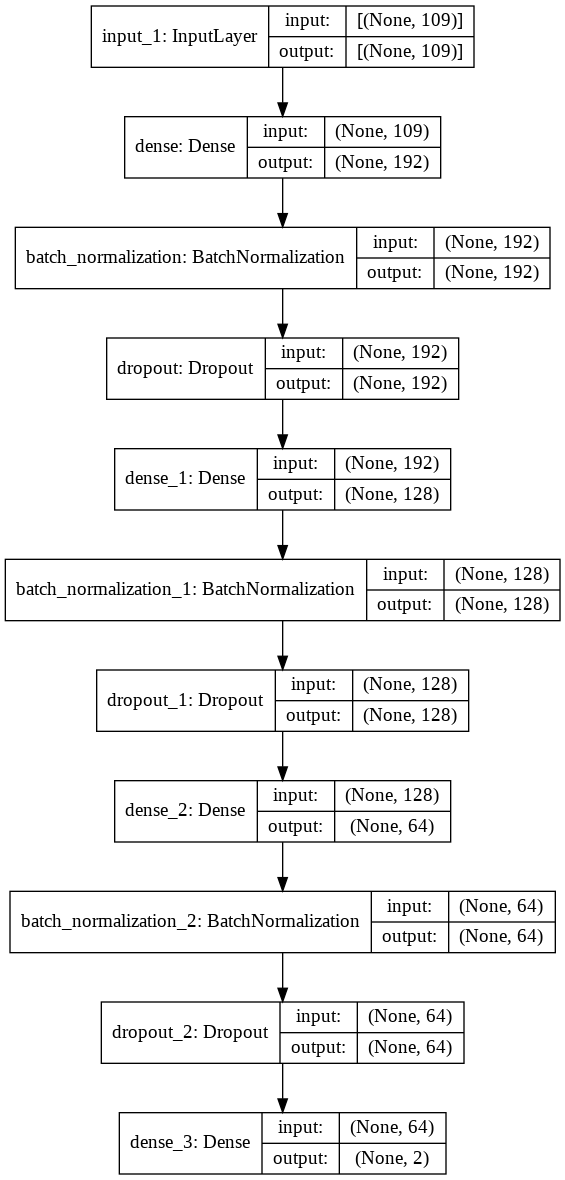

In [46]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [47]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [48]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 8,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [50]:
hitory=model.fit(x=x_train,y=y_train,epochs=50,batch_size=512,validation_data=(x_test, y_test),callbacks=callbacks)

Epoch 1/50
1481/1481 [==============================] - 10s 5ms/step - loss: 1.3504 - accuracy: 0.5084 - val_loss: 0.9883 - val_accuracy: 0.5364

Epoch 00001: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets
Epoch 2/50
1481/1481 [==============================] - 7s 5ms/step - loss: 1.0028 - accuracy: 0.5155 - val_loss: 0.9040 - val_accuracy: 0.5524

Epoch 00002: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets
Epoch 3/50
1481/1481 [==============================] - 7s 5ms/step - loss: 0.8765 - accuracy: 0.5306 - val_loss: 0.8303 - val_accuracy: 0.5536

Epoch 00003: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets
Epoch 4/50
1481/1481 [==============================] - 7s 5ms/step - loss: 0.7980 - accuracy: 0.5484 - val_loss: 0.7642 - val_accuracy: 0.5536

Epoch 00004: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: we

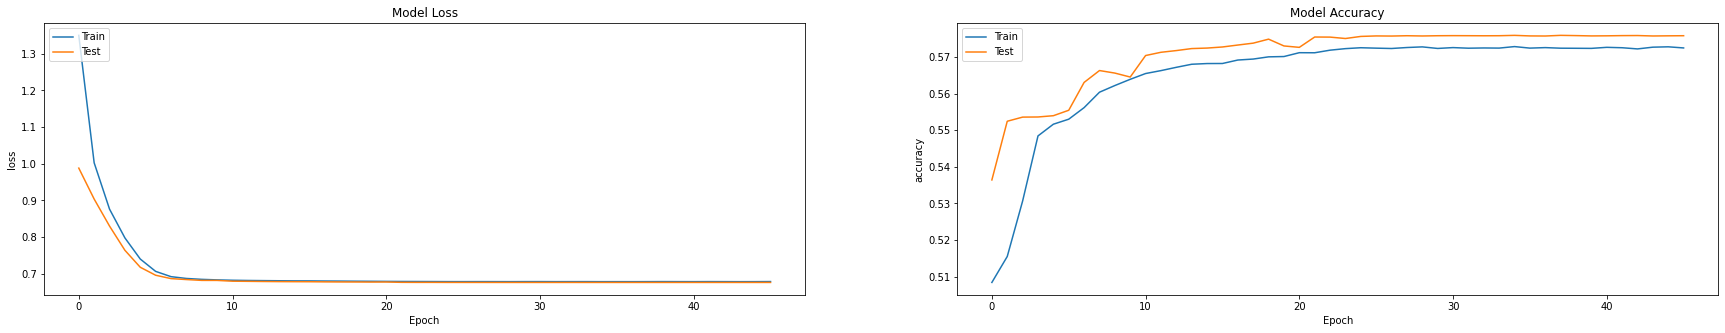

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory.history['loss'])
plt.plot(hitory.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory.history['accuracy'])
plt.plot(hitory.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Model:-2

In [53]:
tf.keras.backend.clear_session()

In [54]:
from tensorflow.keras import regularizers
def simple_mlp_model(input_shape):   
    model_in = Input(shape=(input_shape,), dtype='float32')
    out = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.001))(model_in)
    out = BatchNormalization()(out)
    out = Dropout(0.40)(out)
    out = Dense(256,activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.30)(out)
    out = Dense(128, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.60)(out)
    out = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.30)(out)
    out = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.001))(out)
    out = BatchNormalization()(out)
    out = Dropout(0.15)(out)
    out = Dense(2,activation='softmax')(out)
    model = Model(model_in, out)
    return model

In [55]:
model1=simple_mlp_model(train_s.shape[1])

In [56]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 109)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               56320     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0     

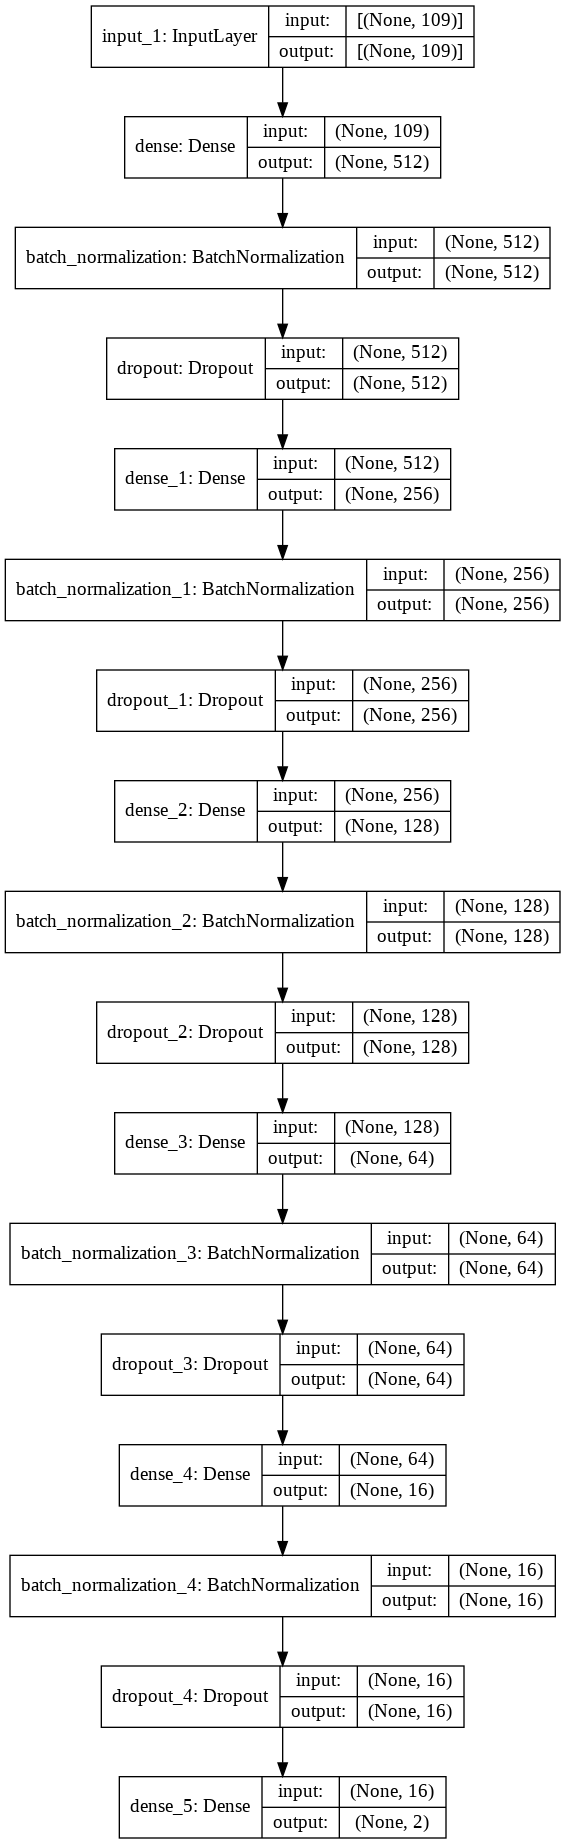

In [57]:
tf.keras.utils.plot_model(
    model1, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [58]:
import tensorflow as tf
adam = tf.keras.optimizers.Adam(lr=0.01)
model1.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

In [59]:
from tensorflow.keras.callbacks import *
import os
filepath="weights_1.best.hdf1"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, mode='max')
earlystop = EarlyStopping(monitor = 'val_accuracy',  mode="max",min_delta = 0, patience = 8,verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.25, patience = 2, verbose = 1)
%reload_ext tensorboard
import datetime
logdir = os.path.join("logs_2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
tensorboard = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_grads=False, write_images=False)
callbacks = [checkpoint,reduce_lr,tensorboard,earlystop]

In [61]:
hitory1=model1.fit(x=x_train,y=y_train,epochs=50,batch_size=1024,validation_data=(x_test, y_test),callbacks=callbacks)

Epoch 1/50
741/741 [==============================] - 7s 7ms/step - loss: 0.7658 - accuracy: 0.5473 - val_loss: 0.7047 - val_accuracy: 0.5416

Epoch 00001: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets
Epoch 2/50
741/741 [==============================] - 5s 6ms/step - loss: 0.7037 - accuracy: 0.5496 - val_loss: 0.7002 - val_accuracy: 0.5554

Epoch 00002: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets
Epoch 3/50
741/741 [==============================] - 5s 6ms/step - loss: 0.7040 - accuracy: 0.5493 - val_loss: 0.7025 - val_accuracy: 0.5457

Epoch 00003: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.best.hdf1/assets
Epoch 4/50
741/741 [==============================] - 5s 6ms/step - loss: 0.7034 - accuracy: 0.5495 - val_loss: 0.6998 - val_accuracy: 0.5439

Epoch 00004: saving model to weights_1.best.hdf1
INFO:tensorflow:Assets written to: weights_1.b

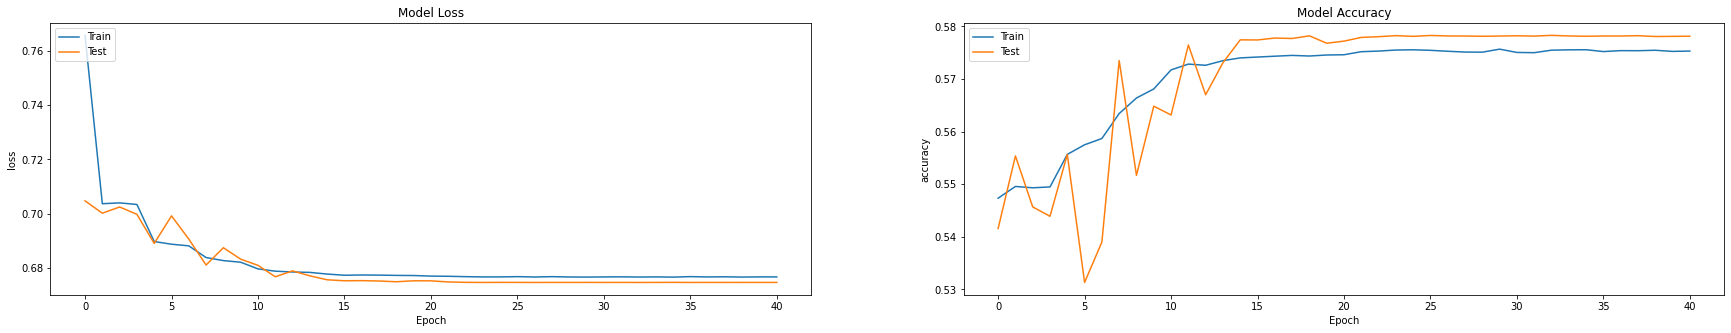

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(hitory1.history['loss'])
plt.plot(hitory1.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation f1_score
plt.subplot(122)
plt.plot(hitory1.history['accuracy'])
plt.plot(hitory1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()